<a href="https://colab.research.google.com/github/MyriadSpace/Concepts_and_Apps_of_Deep_Learning/blob/main/RNN/Germany_Jena_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:

# 독일 예나지역 기상 데이터 다운로드 
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
# CSV 학습 데이터 입력 
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
# 분석에 사용할 특성추출 
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)']
features = df[features_considered]
features.head()

,p (mbar),T (degC),rho (g/m**3),VPact (mbar),VPdef (mbar),sh (g/kg)
0,996.52,-8.02,1307.75,3.11,0.22,1.94
1,996.57,-8.41,1309.80,3.02,0.21,1.89
2,996.53,-8.51,1310.24,3.01,0.20,1.88
3,996.51,-8.31,1309.19,3.07,0.19,1.92
4,996.51,-8.27,1309.00,3.08,0.19,1.92


In [6]:
# 항목명을 제외한 데이터만 추출
dataset = features.values

# 넘파이를 이용한 평균값과 표준편차 계산
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

# 정규화
dataset = (dataset-data_mean)/data_std
dataset

array([[ 0.87422976, -2.0740129 ,  2.29360559, -1.53525603, -0.78058659,
        -1.53697269],
       [ 0.88021172, -2.12031274,  2.34488743, -1.55676573, -0.78262872,
        -1.55579703],
       [ 0.87542615, -2.1321845 ,  2.35589427, -1.5591557 , -0.78467085,
        -1.5595619 ],
       ...,
       [ 1.26903882, -1.49704566,  1.80930485, -1.4946266 , -0.50898314,
        -1.49555915],
       [ 1.26784243, -1.62407343,  1.93863516, -1.51374634, -0.56820494,
        -1.51814835],
       [ 1.26903882, -1.69411678,  2.00917896, -1.50657644, -0.61313183,
        -1.51061862]])

In [7]:
# 학습데이터, 레이블 작성 
# 순환신경망에 입력될 입력데이터 양식에 맞추어 단일 데이터를 만들고 리스트에 저장
def dataset_build(dataset, target, start_index, end_index, past_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + past_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-past_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [8]:
# 어느정도 과거 데이터로 미래를 예측할 지 파라메터 설정
past_timestep = 120
future_timestep = 12
# 데이터 생성시 stride 거리
STEP = 1

# 학습 데이터 / 검증 데이터 분리
TRAIN_SPLIT = 300000

x_train, y_train = dataset_build(dataset, dataset[:, 1], 0,
                                  TRAIN_SPLIT, past_timestep,
                                  future_timestep, STEP)
x_val, y_val = dataset_build(dataset, dataset[:, 1],
                               TRAIN_SPLIT, None, past_timestep,
                               future_timestep, STEP)

In [9]:
print (' Single window of past timesteps : {}'.format(x_train[0].shape))
print ('\n Target temperatures to predict : {}'.format(y_train[0].shape))

 Single window of past timesteps : (120, 6)

 Target temperatures to predict : (12,)


In [10]:
# 한번에 입력할 데이터 수량
BATCH_SIZE = 256

# 셔플링할때 목표 데이터 수량 (학습 데이터를 골고루 섞기위해서)
BUFFER_SIZE = 300000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [11]:
# 분석결과 가시화를 위한 Plot 함수 결정
# 시간축 x 값 생성 
def build_time_steps(length):
  return list(range(-length, 0))

def result_plot(past, true_future, pred_future):
  plt.figure(figsize=(12, 6))
  num_in = build_time_steps(len(past))
  num_out = len(true_future)

  plt.plot(num_in, np.array(past[:, 1]), label='Past')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-',
           label='True Future')
  if pred_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(pred_future), 'r-',
             label='Pred Future')
  plt.legend(loc='upper left')
  plt.show()

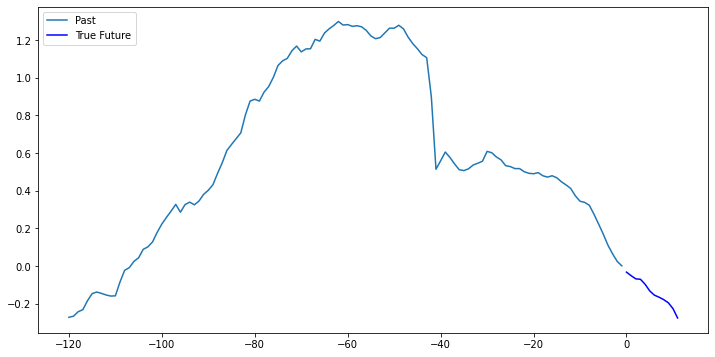

In [12]:
for x, y in train_data.take(1):
  result_plot(x[0], y[0], np.array([0]))

In [13]:
# 순환신경망 모델 설계
# GRU 기반의 시계열 예측모델
# keras에서는 Sequential()을 선언하면 model.add()로 신경망을 계속 쌓을 수 있도록 되어 있음
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(32, activation='relu', return_sequences=True))
model.add(tf.keras.layers.GRU(32, activation='relu', return_sequences=True))
model.add(tf.keras.layers.GRU(32, activation='relu'))

# Dense(N)에서 최종 출력 벡터크기는 예측하고자 하는 timestep 수와 일치 
# Dense(N) = future_timestep (N)
model.add(tf.keras.layers.Dense(12))

# RMSprop 최적화 함수 사용. MSE 로스 함수 적용
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')

In [14]:

# 데이터 포맷 및 크기 확인
for x, y in val_data.take(1):
  print (model.predict(x).shape)

(256, 12)


In [15]:

# 에폭마다 학습 반복횟수
EVALUATION_INTERVAL = 200

# 학습 에포크 정의
EPOCHS = 20

# 학습 시작 
model.fit(train_data, epochs=EPOCHS,
          steps_per_epoch=EVALUATION_INTERVAL,
          validation_data=val_data,
          validation_steps=50)

Epoch 1/20
200/200 [==============================] - 73s 345ms/step - loss: 0.2879 - val_loss: 0.0162
Epoch 2/20
200/200 [==============================] - 70s 349ms/step - loss: 0.0248 - val_loss: 0.0148
Epoch 3/20
200/200 [==============================] - 70s 349ms/step - loss: 0.0200 - val_loss: 0.0142
Epoch 4/20
200/200 [==============================] - 70s 348ms/step - loss: 0.0172 - val_loss: 0.0143
Epoch 5/20
200/200 [==============================] - 70s 349ms/step - loss: 0.0156 - val_loss: 0.0113
Epoch 6/20
200/200 [==============================] - 67s 335ms/step - loss: 0.0152 - val_loss: 0.0091
Epoch 7/20
200/200 [==============================] - 70s 352ms/step - loss: 0.0146 - val_loss: 0.0108
Epoch 8/20
200/200 [==============================] - 73s 363ms/step - loss: 0.0140 - val_loss: 0.0082
Epoch 9/20
200/200 [==============================] - 72s 360ms/step - loss: 0.0131 - val_loss: 0.0102
Epoch 10/20
200/200 [==============================] - 75s 375ms/step - l

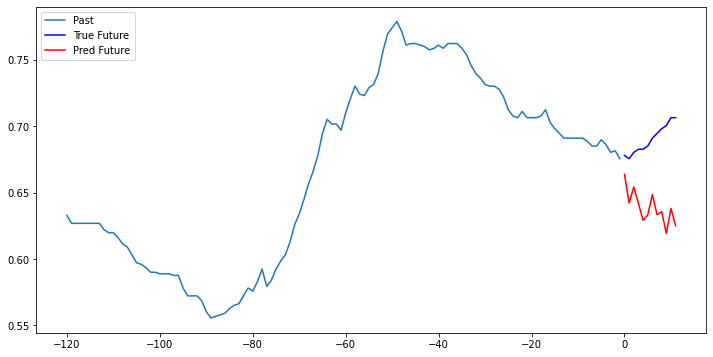

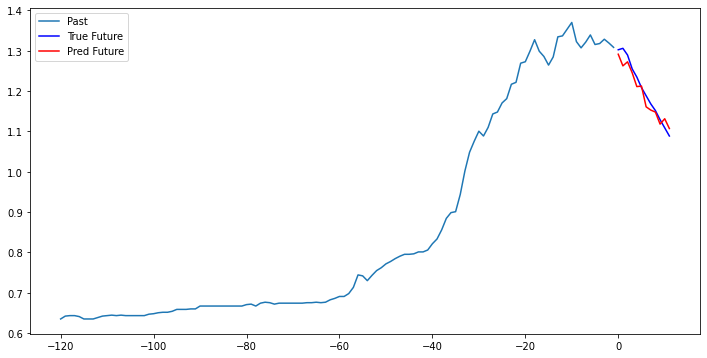

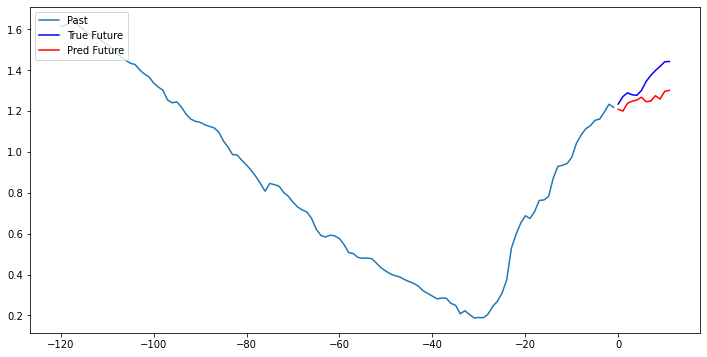

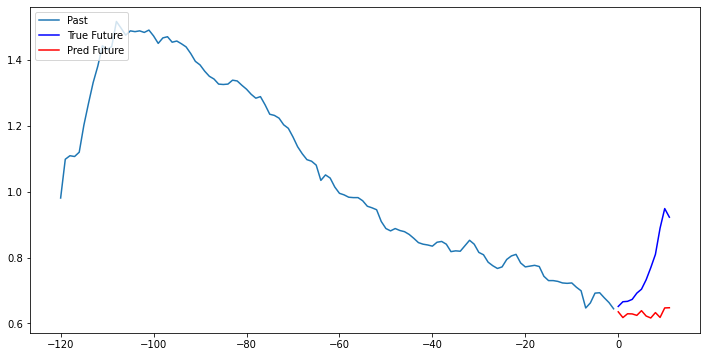

In [16]:
# 검증: 예측 결과 출력
for x, y in val_data.take(4):
  result_plot(x[0], y[0], model.predict(x)[0])